# Caveman ML

In [195]:
import typing as T

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

rng = np.random.default_rng()

np.set_printoptions(
    linewidth=180,
    edgeitems=14,
    formatter={
        "float": lambda x: f"{x:7.3f}",
        "int": lambda x: f"{x:3}",
    },
)


## Data Import

In [196]:
image_data_df = pd.read_csv("archive/mnist_train.csv")
image_data_df


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [197]:
labels = [0, 1]
image_data_all = image_data_df[image_data_df.label.isin(labels)].to_numpy()
image_data = image_data_all[:, 1:].reshape((-1, 28, 28))
label_data = image_data_all[:, 0].reshape(-1)


## Demo

In [198]:
active_cell_count = image_data.clip(max=1, min=0).sum(axis=(1, 2))
active_cell_count


array([176,  96,  93,  68,  75, 198,  95, 139, 183, 200,  82, 234, 219,  94, ..., 195,  90, 150, 144, 156, 174,  88,  74,  97, 204,  76,  96, 197,  74], dtype=int64)

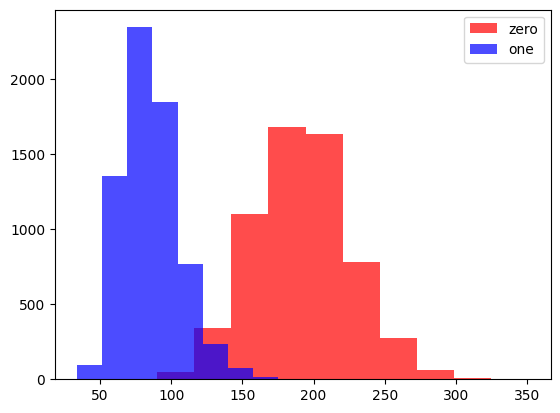

In [199]:
plt.hist(active_cell_count[label_data == 0], alpha=0.7, color="red", label="zero")
plt.hist(active_cell_count[label_data == 1], alpha=0.7, color="blue", label="one")
plt.legend()


In [200]:
predictions = np.where(image_data.clip(min=0, max=1).sum(axis=(1, 2)) < 125, 1, 0)
acc = (predictions == label_data).mean()
acc


0.9698381365969206

In [201]:
label_data.dtype


dtype('int64')

## Types

In [202]:
class IModel:
    def predict(self, X: np.ndarray, params: dict[str, np.ndarray] = None):
        raise NotImplementedError()


In [203]:
# (-1,28,28) -> (-1,1)
TFeaturizer = T.Callable[[np.ndarray], np.ndarray]
TEvaluate = T.Callable[[np.ndarray], np.ndarray]
TPredictor = T.Callable[[np.ndarray], np.ndarray]


## Visualizations

In [265]:
def histogram_featurizer(
    featurizer: TFeaturizer,
    imgage_data: np.ndarray,
    label_data: np.ndarray,
    labels: T.List[int],
    **kwargs,
):
    fig, ax = plt.subplots()
    for label in labels:
        bins = 20
        alpha = 0.7
        ax.hist(
            featurizer(image_data[label_data == label]),
            bins=bins,
            alpha=alpha,
            label=f"label: {label}",
            **kwargs,
        )
    ax.legend()
    return fig, ax


## Model

### Metrics

In [205]:
def accuracy(predictor: TPredictor, X: np.ndarray, y: np.ndarray) -> np.float64:
    return (predictor(X) == y).mean()


### Features

In [217]:
class KernelFeaturizer:
    def __init__(self, kernel: np.ndarray = None, clip_min=0, clip_max=1):
        """kernel: (28,28)"""
        self.clip_min = clip_min
        self.clip_max = clip_max
        self.kernel = kernel

    def get_kernel(self) -> np.ndarray:
        return self.kernel
    
    def __call__(self, image_data: np.ndarray, params: dict[str, np.ndarray] = None) -> np.ndarray:
        """(-1,28,28) -> (-1,1)"""
        kernel = (params or {}).get('kernel', None) or self.kernel
        return (image_data.clip(min=self.clip_min, max=self.clip_max)*kernel.reshape(1,28,28)).sum(axis=(1,2))


In [261]:
class LinearKernelFeaturizer(KernelFeaturizer):
    def __init__(self, basis: np.ndarray, coefficients: np.ndarray = None, **kwargs):
        super().__init__(**kwargs)
        self.basis = basis
        self.coefficients = coefficients if coefficients is not None else np.zeros(basis.shape[0])
    
    def get_kernel(self, params: dict[str, np.ndarray] = None) -> np.ndarray:
        coefficients = (params or {}).get('coefficients', self.coefficients)
        return (coefficients.reshape((-1,1,1))*self.basis).sum(axis=0)
    
    def __call__(self, image_data: np.ndarray, params: dict[str, np.ndarray] = None) -> np.ndarray:
        """(-1,28,28) -> (-1,1)"""
        kernel = (params or {}).get('kernel', self.get_kernel(params))
        return (image_data.clip(min=self.clip_min, max=self.clip_max)*kernel.reshape(1,28,28)).sum(axis=(1,2))

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

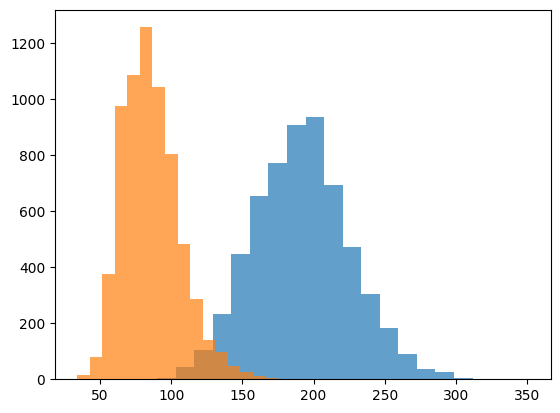

In [257]:
total_active_cells_feature = KernelFeaturizer(np.ones((28,28)))

histogram_featurizer(
    total_active_cells_feature, imgage_data=image_data, label_data=label_data, labels=labels
)

(<Figure size 640x480 with 1 Axes>, <AxesSubplot: >)

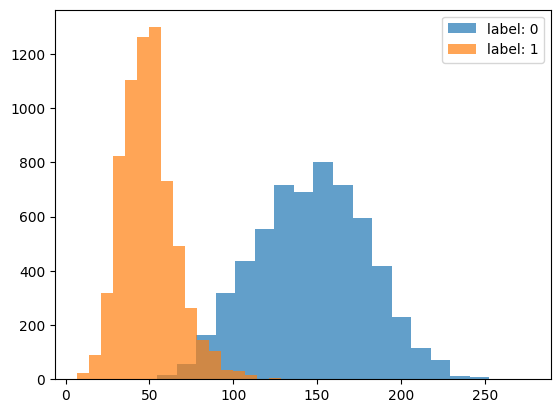

In [298]:
lk_featurizer = LinearKernelFeaturizer(get_basis(), np.array([1,1,0,1, 0,0,0,1]))

histogram_featurizer(
    lk_featurizer, imgage_data=image_data, label_data=label_data, labels=labels
)

### Feature Selection

In [282]:
def expected_difference(
    featurizer: TFeaturizer,
    X1: np.ndarray,
    X2: np.ndarray,
    **kwargs,
) -> np.float64:
    f1 = featurizer(X1, **kwargs)
    f2 = featurizer(X2, **kwargs)
    alpha = 20
    return np.abs(f1.mean() - f2.mean()) / ((alpha + f1.std()) * (alpha + f2.std()))


expected_difference(
    total_active_cells_feature, image_data[label_data == 0], image_data[label_data == 1]
)


0.04943531530436773

In [283]:
class LinearKernelFeaturizerScorer:
    def __init__(
        self,
        linear_kernel_featurizer: LinearKernelFeaturizer,
        image_data=image_data,
        label_data=label_data,
        labels: T.List[int] = labels,
    ):
        self.linear_kernel_featurizer = linear_kernel_featurizer
        self.image_data = image_data
        self.label_data = label_data
        self.labels = labels
        self.l0_data = self.image_data[self.label_data == self.labels[0]]
        self.l1_data = self.image_data[self.label_data == self.labels[1]]

    def __call__(self, coefficients: np.ndarray) -> float:
        delta = expected_difference(
            self.linear_kernel_featurizer,
            self.l0_data,
            self.l1_data,
            params={"coefficients": coefficients},
        )
        return delta


In [284]:
def get_basis() -> np.ndarray:
    z = np.zeros((28,7))
    o = np.ones((28,7))
    return np.stack([
        np.hstack([o,z,z,z]),
        np.hstack([z,o,z,z]),
        np.hstack([z,z,o,z]),
        np.hstack([z,z,z,o]),
        np.hstack([o,z,z,z]).T,
        np.hstack([z,o,z,z]).T,
        np.hstack([z,z,o,z]).T,
        np.hstack([z,z,z,o]).T,
    ])

get_basis().shape

(8, 28, 28)

### Training

In [285]:
from itertools import product

TMin = TMax = float
TCount = int
TParamName = str


def grid_search(f: TEvaluate, param_spec: T.Dict[TParamName, T.Tuple[TMin, TMax, TCount]]):
    _key_order = tuple(param_spec.keys())
    grid = np.array(list(product(*[np.linspace(*param_spec[_key]) for _key in _key_order])))
    flat_grid = grid.reshape(-1, len(_key_order))
    evaluation_results = np.apply_along_axis(f, 1, flat_grid)
    results = np.hstack(
        [flat_grid.reshape((-1, len(_key_order))), evaluation_results.reshape((-1, 1))]
    )
    return np.flip(results[np.argsort(results[:,-1])], axis=0)



In [286]:
linear_kernel_featurizer = LinearKernelFeaturizer(get_basis(), coefficients=np.ones(8))
kernel_featurizer_scorer = LinearKernelFeaturizerScorer(linear_kernel_featurizer)
# kernel_featurizer_scorer(np.ones(8)*0)
kernel_search_results = grid_search(kernel_featurizer_scorer, param_spec={
    f'{coefficient_i}': (0,1,2) for coefficient_i in range(linear_kernel_featurizer.basis.shape[0])
})

kernel_search_results

array([[  0.000,   0.000,   0.000,   1.000,   1.000,   1.000,   0.000,   1.000,   0.051],
       [  0.000,   0.000,   0.000,   1.000,   0.000,   0.000,   1.000,   1.000,   0.051],
       [  1.000,   1.000,   0.000,   1.000,   0.000,   0.000,   0.000,   1.000,   0.051],
       [  0.000,   0.000,   0.000,   1.000,   1.000,   1.000,   0.000,   0.000,   0.051],
       [  0.000,   0.000,   0.000,   1.000,   0.000,   1.000,   0.000,   1.000,   0.051],
       [  1.000,   1.000,   0.000,   1.000,   0.000,   0.000,   0.000,   0.000,   0.050],
       [  0.000,   0.000,   0.000,   1.000,   1.000,   0.000,   1.000,   1.000,   0.050],
       [  0.000,   1.000,   0.000,   1.000,   0.000,   0.000,   0.000,   1.000,   0.050],
       [  0.000,   1.000,   0.000,   1.000,   0.000,   1.000,   0.000,   0.000,   0.050],
       [  1.000,   0.000,   0.000,   1.000,   1.000,   1.000,   0.000,   1.000,   0.050],
       [  1.000,   1.000,   0.000,   1.000,   1.000,   0.000,   0.000,   0.000,   0.050],
       [  

In [287]:
grid_search(lambda x: x[0] * x[1], {"x": (0, 3, 4), "y": (0, 3, 4)})


array([[  3.000,   3.000,   9.000],
       [  3.000,   2.000,   6.000],
       [  2.000,   3.000,   6.000],
       [  2.000,   2.000,   4.000],
       [  3.000,   1.000,   3.000],
       [  1.000,   3.000,   3.000],
       [  2.000,   1.000,   2.000],
       [  1.000,   2.000,   2.000],
       [  1.000,   1.000,   1.000],
       [  3.000,   0.000,   0.000],
       [  2.000,   0.000,   0.000],
       [  1.000,   0.000,   0.000],
       [  0.000,   3.000,   0.000],
       [  0.000,   2.000,   0.000],
       [  0.000,   1.000,   0.000],
       [  0.000,   0.000,   0.000]])

### Models

In [288]:
class MyFirstBinaryClassifier(IModel):
    def __init__(
        self,
        featurizer: TFeaturizer,
        threshold: float,
        label_left: int,
        label_right: int,
    ):
        self.featurizer = featurizer
        self.threshold = threshold
        self.label_left = label_left
        self.label_right = label_right

    def predict(self, X: np.ndarray, params: dict[str, np.ndarray] = None) -> np.ndarray:
        """(-1,28,28) -> (-1,1)"""
        threshold = (params or {}).get("threshold", None) or self.threshold
        return np.where(self.featurizer(X) < threshold, self.label_left, self.label_right)


In [295]:
model = MyFirstBinaryClassifier(
    featurizer=total_active_cells_feature,
    threshold=125,
    label_left=labels[1],
    label_right=labels[0],
)

# predictions = model.predict(image_data)
# accuracy(model.predict, image_data, label_data)


def evaluate_model(parmas: np.ndarray) -> np.float64:
    def _predict(image_data: np.ndarray) -> np.ndarray:
        return model.predict(image_data, params={'threshold': parmas})
    return accuracy(_predict, image_data, label_data)

initial_result = evaluate_model(np.array([125.]))
search_results = grid_search(evaluate_model, {'threshold': (110,140,256)})
initial_result, search_results[:20]


(0.9698381365969206,
 array([[132.000,   0.972],
        [131.882,   0.972],
        [131.765,   0.972],
        [131.647,   0.972],
        [131.529,   0.972],
        [131.412,   0.972],
        [131.294,   0.972],
        [131.176,   0.972],
        [131.059,   0.972],
        [129.176,   0.972],
        [129.294,   0.972],
        [130.000,   0.972],
        [129.882,   0.972],
        [129.765,   0.972],
        [129.647,   0.972],
        [129.529,   0.972],
        [129.412,   0.972],
        [129.059,   0.972],
        [130.471,   0.972],
        [130.353,   0.972]]))

In [302]:
_min = 60
_max = 100

model = MyFirstBinaryClassifier(
    featurizer=lk_featurizer,
    threshold=_min,
    label_left=labels[1],
    label_right=labels[0],
)

# predictions = model.predict(image_data)
# accuracy(model.predict, image_data, label_data)


def evaluate_model(parmas: np.ndarray) -> np.float64:
    def _predict(image_data: np.ndarray) -> np.ndarray:
        return model.predict(image_data, params={'threshold': parmas})
    return accuracy(_predict, image_data, label_data)

search_results = grid_search(evaluate_model, {'threshold': (_min,_max,256)})
search_results[:20]


array([[ 86.667,   0.973],
       [ 86.039,   0.973],
       [ 86.196,   0.973],
       [ 86.353,   0.973],
       [ 86.510,   0.973],
       [ 86.824,   0.973],
       [ 86.980,   0.973],
       [ 87.137,   0.973],
       [ 87.922,   0.973],
       [ 87.765,   0.973],
       [ 87.451,   0.973],
       [ 87.294,   0.973],
       [ 87.608,   0.973],
       [ 89.020,   0.972],
       [ 89.490,   0.972],
       [ 89.333,   0.972],
       [ 89.647,   0.972],
       [ 89.804,   0.972],
       [ 89.176,   0.972],
       [ 89.961,   0.972]])

In [291]:
initial_result, search_results[:20]

(0.5323332017370707,
 array([[120.000,   0.532],
        [119.843,   0.532],
        [ 94.588,   0.532],
        [ 94.431,   0.532],
        [ 94.275,   0.532],
        [ 94.118,   0.532],
        [ 93.961,   0.532],
        [ 93.804,   0.532],
        [ 93.647,   0.532],
        [ 93.490,   0.532],
        [ 93.333,   0.532],
        [ 93.176,   0.532],
        [ 93.020,   0.532],
        [ 92.863,   0.532],
        [ 92.706,   0.532],
        [ 92.549,   0.532],
        [ 92.392,   0.532],
        [ 92.235,   0.532],
        [ 92.078,   0.532],
        [ 91.922,   0.532]]))

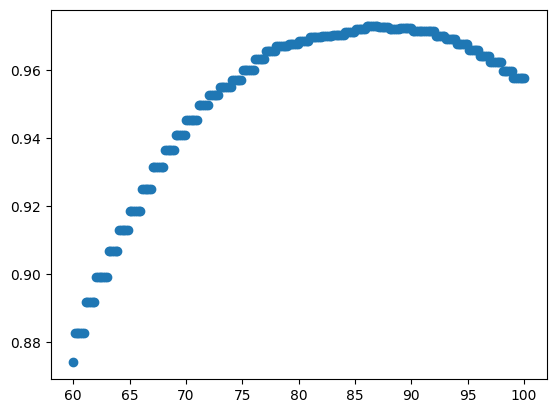

In [303]:
plt.scatter(search_results[:,0], search_results[:,1])